source link : https://affine.medium.com/natural-language-inferencing-nli-task-demonstration-using-kaggle-dataset-34cbce0f0852

In [1]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report
import torch

In [2]:
xlmr = AutoModelForSequenceClassification.from_pretrained('joeddav/xlm-roberta-large-xnli')

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
tokenizer = AutoTokenizer.from_pretrained('joeddav/xlm-roberta-large-xnli')

In [4]:
train_data = pd.read_csv("../data/train.csv")
# train_data = pd.read_csv("../data/translated_data_train.csv")
train_data.head(3)

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0


In [5]:
test_data = pd.read_csv("../data/test.csv")
# test_data = pd.read_csv("../data/translated_data_test.csv")
test_data.head(3)

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French


# match model labels and dataset labels

In [6]:
xlmr.config.label2id

{'contradiction': 0, 'entailment': 2, 'neutral': 1}

In [7]:
train_data['label'] = train_data['label'].replace([0, 2], [2, 0])
train_data.head(3)

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,2
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,0
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,2


# See accuracy with train dataset

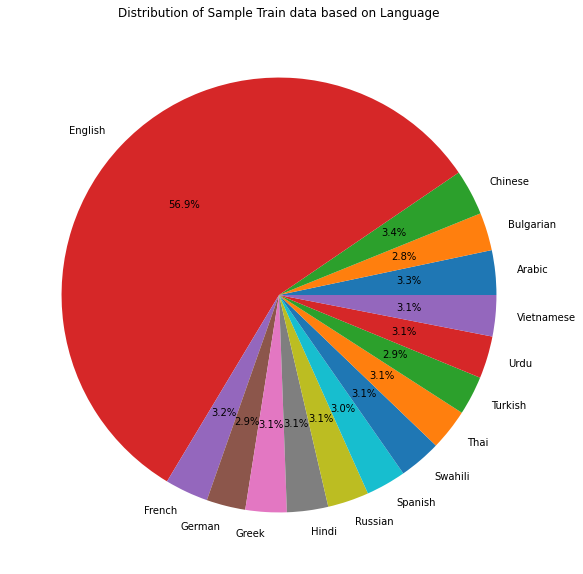

In [8]:
train_data_lang = train_data.groupby('language').count().reset_index()[['language', 'id']]
# create a column which tells how many random rows should be extracted for each language
train_data_lang['sample_count'] = train_data_lang['id'] / 10

# sample data
sample_train_data = pd.DataFrame(columns=train_data.columns)
for i in range(len(train_data_lang)):
    df = train_data[train_data['language'] == train_data_lang['language'][i]]
    n = int(train_data_lang['sample_count'][i])
    df = df.sample(n).reset_index(drop=True)
    sample_train_data = sample_train_data.append(df)
    sample_train_data = sample_train_data.reset_index(drop=True)

# plot distribution of sample data based on language
sample_train_data_lang = sample_train_data.groupby('language').count().reset_index()[['language', 'id']]
plt.figure(figsize=(10, 10))
plt.pie(sample_train_data_lang['id'], labels=sample_train_data_lang['language'], autopct='%1.1f%%')
plt.title('Distribution of Sample Train data based on Language')
plt.show()

In [10]:
def get_tokens_xlmr_model(data):
    """ Function which creates tokens for the passed data using XLM-R model
    input — Dataframe
    Output — list of tokens """
    batch_tokens = []
    for i in range(len(data)):
        tokens = tokenizer.encode(data['premise'][i], data['hypothesis'][i], return_tensors='pt',
                                  truncation='only_first')
        batch_tokens.append(tokens)
    return batch_tokens

In [11]:
def get_predicts_xlmr_model(tokens):
    """ Function which creates predictions for the passed tokens using XLM-R model
    input — list of tokens
    Output — list of predictions """
    import time
    avg_elapsed = 0
    t_total = time.time()
    batch_predicts = []
    count=0
    for i in tokens:
        t = time.time()
        predict = xlmr(i)[0][0]
        predict = int(predict.argmax())
        batch_predicts.append(predict)
        count+=1
        avg_elapsed = (avg_elapsed * (count-1) + (time.time() - t)) / count
        if count % 100 == 0:
            print(str(count).rjust(6),"/",len(tokens))
            print("avg_elapsed :",np.round(avg_elapsed,2),"s. - ETA :",np.round(avg_elapsed * (len(tokens)-count),2),"s. - elapsed :",np.round(time.time()-t_total,2),"s.\n")
    return batch_predicts

In [12]:
sample_train_data_tokens = get_tokens_xlmr_model(sample_train_data)
sample_train_data_predictions = get_predicts_xlmr_model(sample_train_data_tokens)

   100 / 1208
avg_elapsed : 0.29 s. - ETA : 319.68 s. - elapsed : 28.85 s.

   200 / 1208
avg_elapsed : 0.3 s. - ETA : 299.3 s. - elapsed : 59.39 s.

   300 / 1208
avg_elapsed : 0.31 s. - ETA : 284.09 s. - elapsed : 93.86 s.

   400 / 1208
avg_elapsed : 0.31 s. - ETA : 254.26 s. - elapsed : 125.88 s.

   500 / 1208
avg_elapsed : 0.31 s. - ETA : 217.89 s. - elapsed : 153.89 s.

   600 / 1208
avg_elapsed : 0.32 s. - ETA : 193.81 s. - elapsed : 191.27 s.

   700 / 1208
avg_elapsed : 0.32 s. - ETA : 164.2 s. - elapsed : 226.27 s.

   800 / 1208
avg_elapsed : 0.33 s. - ETA : 132.9 s. - elapsed : 260.6 s.

   900 / 1208
avg_elapsed : 0.33 s. - ETA : 101.95 s. - elapsed : 297.93 s.

  1000 / 1208
avg_elapsed : 0.33 s. - ETA : 68.86 s. - elapsed : 331.09 s.

  1100 / 1208
avg_elapsed : 0.33 s. - ETA : 35.83 s. - elapsed : 364.96 s.

  1200 / 1208
avg_elapsed : 0.33 s. - ETA : 2.67 s. - elapsed : 401.21 s.



# Find model accuracy on the predictions

/tmp/ipykernel_180639/3600761344.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  np.add.at(cm, [x, y], 1)


Classification report : 
                precision    recall  f1-score   support

contradiction       0.94      0.93      0.94       405
      neutral       0.90      0.87      0.89       391
   entailment       0.91      0.95      0.93       412

     accuracy                           0.92      1208
    macro avg       0.92      0.92      0.92      1208
 weighted avg       0.92      0.92      0.92      1208



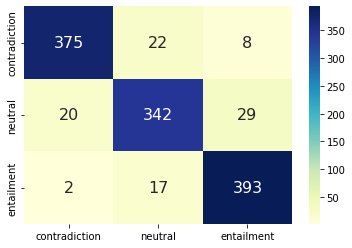

In [13]:
# plot the confusion matrix and classification report for original labels to the predicted labels
sample_train_data['label'] = sample_train_data['label'].astype(str).astype(int)
x = np.array(sample_train_data['label'])
y = np.array(sample_train_data_predictions)
cm = np.zeros((3, 3), dtype=int)
np.add.at(cm, [x, y], 1)
sns.heatmap(cm, cmap="YlGnBu", annot=True, annot_kws={'size': 16}, fmt='g',
            xticklabels=['contradiction', 'neutral', 'entailment'],
            yticklabels=['contradiction', 'neutral', 'entailment'])
matrix = classification_report(x, y, labels=[0, 1, 2], target_names=['contradiction', 'neutral', 'entailment'])
print('Classification report : \n', matrix)

# Find model accuracy at language level

In [14]:
sample_train_data['prediction'] = sample_train_data_predictions
sample_train_data['true_prediction'] = np.where(sample_train_data['label']==sample_train_data['prediction'], 1, 0)
sample_train_data_predicted_lang = sample_train_data.groupby('language').agg({'id':'count', 'true_prediction':'sum'}).reset_index()[['language','id','true_prediction']]
sample_train_data_predicted_lang['accuracy'] = round(sample_train_data_predicted_lang['true_prediction']/sample_train_data_predicted_lang['id'], 2)
sample_train_data_predicted_lang = sample_train_data_predicted_lang.sort_values(by=['accuracy'],ascending=False)
sample_train_data_predicted_lang

,language,id,true_prediction,accuracy
0,Arabic,40,40,1.00
1,Bulgarian,34,34,1.00
4,French,39,39,1.00
5,German,35,35,1.00
6,Greek,37,37,1.00
7,Hindi,37,37,1.00
9,Spanish,36,36,1.00
10,Swahili,38,38,1.00
11,Thai,37,37,1.00
12,Turkish,35,35,1.00


# Predict

In [15]:
test_data["token"] = get_tokens_xlmr_model(test_data)

In [16]:
test_data["prediction"] = get_predicts_xlmr_model(test_data["token"])

   100 / 5195
avg_elapsed : 0.3 s. - ETA : 1511.01 s. - elapsed : 29.66 s.

   200 / 5195
avg_elapsed : 0.28 s. - ETA : 1373.88 s. - elapsed : 55.01 s.

   300 / 5195
avg_elapsed : 0.26 s. - ETA : 1259.37 s. - elapsed : 77.19 s.

   400 / 5195
avg_elapsed : 0.24 s. - ETA : 1173.41 s. - elapsed : 97.89 s.

   500 / 5195
avg_elapsed : 0.24 s. - ETA : 1125.68 s. - elapsed : 119.88 s.

   600 / 5195
avg_elapsed : 0.24 s. - ETA : 1100.04 s. - elapsed : 143.64 s.

   700 / 5195
avg_elapsed : 0.24 s. - ETA : 1061.1 s. - elapsed : 165.25 s.

   800 / 5195
avg_elapsed : 0.23 s. - ETA : 1023.13 s. - elapsed : 186.24 s.

   900 / 5195
avg_elapsed : 0.23 s. - ETA : 992.13 s. - elapsed : 207.9 s.

  1000 / 5195
avg_elapsed : 0.23 s. - ETA : 958.67 s. - elapsed : 228.54 s.

  1100 / 5195
avg_elapsed : 0.23 s. - ETA : 930.12 s. - elapsed : 249.86 s.

  1200 / 5195
avg_elapsed : 0.23 s. - ETA : 903.31 s. - elapsed : 271.34 s.

  1300 / 5195
avg_elapsed : 0.23 s. - ETA : 883.69 s. - elapsed : 294.95 s.

In [17]:
test_data.head()

,id,premise,hypothesis,lang_abv,language,token,prediction
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu,"[[tensor(0), tensor(676), tensor(20658), tenso...",0
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic,"[[tensor(0), tensor(2433), tensor(1638), tenso...",1
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French,"[[tensor(0), tensor(82), tensor(10804), tensor...",2
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese,"[[tensor(0), tensor(6), tensor(1189), tensor(7...",1
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian,"[[tensor(0), tensor(12786), tensor(1203), tens...",1


# match model labels and dataset labels

In [18]:
test_data['prediction'] = test_data['prediction'].replace([0, 2], [2, 0])

In [19]:
test_data.head()

,id,premise,hypothesis,lang_abv,language,token,prediction
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu,"[[tensor(0), tensor(676), tensor(20658), tenso...",2
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic,"[[tensor(0), tensor(2433), tensor(1638), tenso...",1
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French,"[[tensor(0), tensor(82), tensor(10804), tensor...",0
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese,"[[tensor(0), tensor(6), tensor(1189), tensor(7...",1
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian,"[[tensor(0), tensor(12786), tensor(1203), tens...",1


In [20]:
submission = test_data[["id","prediction"]]

In [21]:
submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,1


In [22]:
submission.to_csv("submission_xlm-r.csv",index=False)